In [1]:
import pandas as pd
import yfinance as yf
import talib as ta
import numpy as np
import math

from finvizfinance.screener.overview import Overview
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [2]:
criteria = Overview()

# Criteria Set from CANSLIM method
filters_dic = {'Price':'Over $5', 'EPS growthqtr over qtr':'Over 20%', 'EPS growthpast 5 years':'Over 15%', 'InstitutionalOwnership':'Under 90%', 
               'Return on Equity':'Over +15%', '52-Week High/Low':'0-10% below High', 'Shares Outstanding': 'Under 50M', 'Price': 'Over $5', 'Average Volume': 'Over 100K'}

criteria.set_filter(filters_dict=filters_dic)

screened_stocks_df = criteria.screener_view()
screened_stocks_df

,Ticker,Company,Sector,Industry,Country,Market Cap,P/E,Price,Change,Volume
0,CLFD,"Clearfield, Inc.",Technology,Communication Equipment,USA,1.210000e+09,43.10,103.02,-0.0056,281565.0
1,CVLG,"Covenant Logistics Group, Inc.",Industrials,Trucking,USA,5.177500e+08,6.72,32.79,0.0403,134089.0
2,GLP,Global Partners LP,Energy,Oil & Gas Midstream,USA,9.426700e+08,12.45,28.30,-0.0018,90589.0
3,MGPI,"MGP Ingredients, Inc.",Consumer Defensive,Packaged Foods,USA,2.230000e+09,20.19,101.95,-0.0414,157615.0
4,MUSA,Murphy USA Inc.,Consumer Cyclical,Specialty Retail,USA,6.300000e+09,13.19,287.55,0.0139,268666.0
5,OTTR,Otter Tail Corporation,Utilities,Utilities - Diversified,USA,3.020000e+09,14.43,75.30,-0.0391,290545.0
6,SRTS,"Sensus Healthcare, Inc.",Healthcare,Medical Devices,USA,1.768000e+08,8.71,11.19,0.0090,184328.0
7,USAK,"USA Truck, Inc.",Industrials,Trucking,USA,2.815200e+08,8.21,31.28,0.0026,127419.0


In [4]:
tickers = list(screened_stocks_df.Ticker)
tickers

['CLFD', 'CVLG', 'GLP', 'MGPI', 'MUSA', 'OTTR', 'SRTS', 'USAK']

In [5]:
yf_data = yf.download(tickers, '2021-01-01','2022-07-30')

[*********************100%***********************]  8 of 8 completed


In [6]:
all_stock_df = {}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
947/947 [==============================] - 13s 11ms/step - loss: 5.6693e-04
Epoch 2/3
947/947 [==============================] - 11s 12ms/step - loss: 2.6126e-04
Epoch 3/3


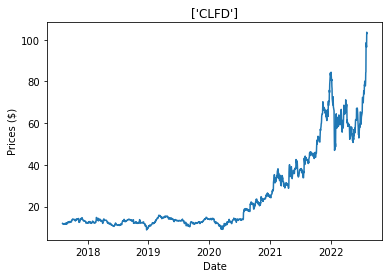

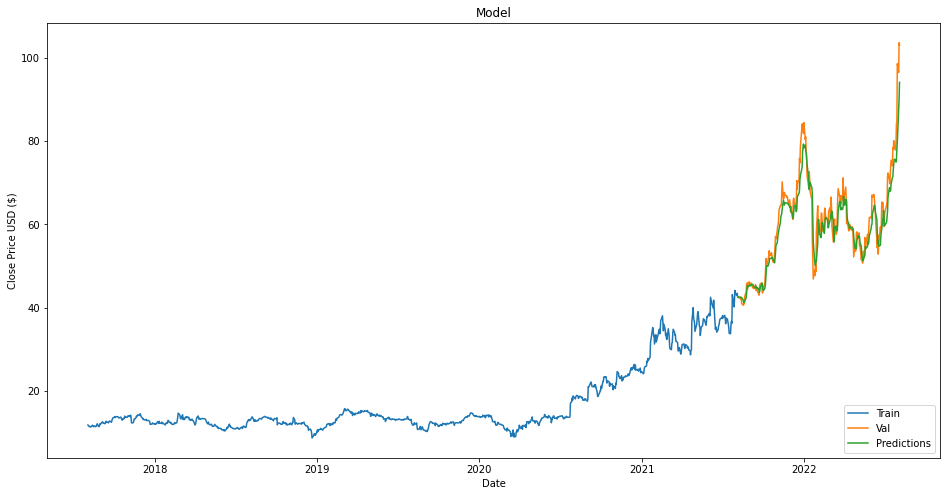

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
947/947 [==============================] - 12s 11ms/step - loss: 0.0036
Epoch 2/3
947/947 [==============================] - 11s 11ms/step - loss: 0.0015
Epoch 3/3
8/8 [=

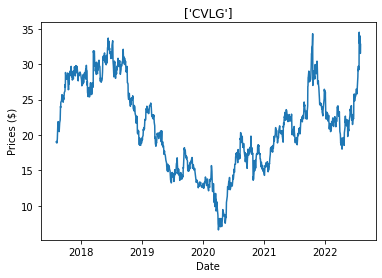

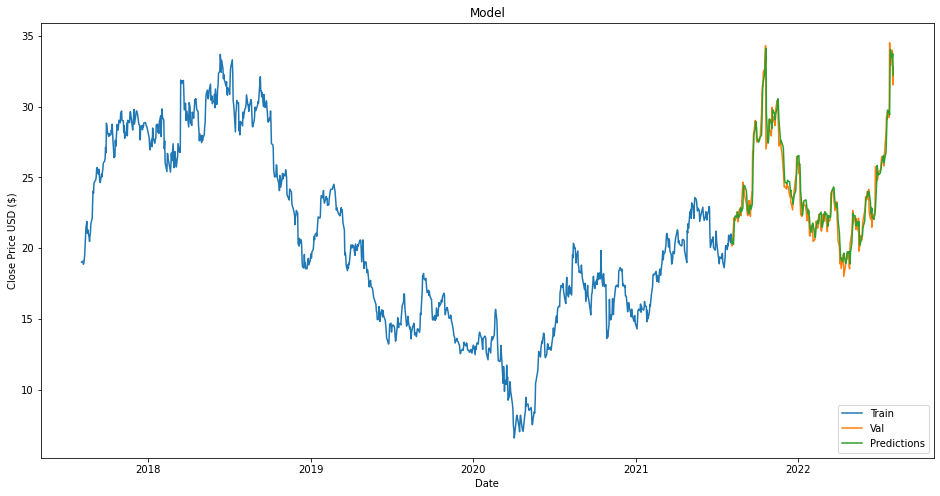

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 25)                2525      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
454/947 [=============>................] - ETA: 5s - loss: 0.0026

KeyboardInterrupt: 

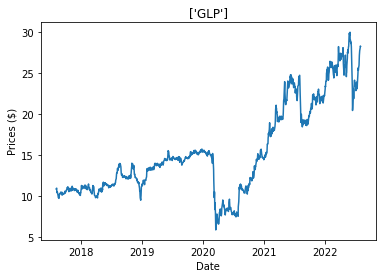

In [7]:
for ticker in tickers:
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period='5y')
    stock_hist = stock_hist.drop(columns=["Dividends", "Stock Splits"])
    stock_hist['Ticker'] = (ticker)
    col = stock_hist.pop('Ticker')
    stock_hist.insert(loc=0, column='Ticker', value=col)
    stock_hist.dropna()
    all_stock_df[ticker] = pd.DataFrame(stock_hist)
    
    plt.figure()
    plt.title([ticker])
    plt.plot(all_stock_df[ticker]['Close'])
    plt.xlabel('Date')
    plt.ylabel('Prices ($)')
    
    close_prices = all_stock_df[ticker]['Close']
    values = close_prices.values
    training_data_len = math.ceil(len(values)* 0.8)

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(values.reshape(-1,1))
    train_data = scaled_data[0: training_data_len, :]

    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    test_data = scaled_data[training_data_len-60: , : ]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    model.summary()
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size= 1, epochs=3)
    
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    rmse
    
    data = all_stock_df[ticker].filter(['Close'])
    train = data[:training_data_len]
    validation = data[training_data_len:]
    validation['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price USD ($)')
    plt.plot(train)
    plt.plot(validation[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()